In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt

import scipy.interpolate as interpolate
import scipy.optimize as optimize

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import imp

import plotparams
imp.reload(plotparams)
from plotparams import *

import constants
imp.reload(constants)
from constants import *

import waveform
imp.reload(waveform)
from waveform import *

import pycbcwaveform
imp.reload(pycbcwaveform)
from pycbcwaveform import *

import taylorf2
imp.reload(taylorf2)
from taylorf2 import *

__init__: Setting weave cache to /var/folders/zl/bw0yy2l15g339xpfq2gmxh7c0000gn/T/501_python27_compiled/0f9d09/0f9d091579730f944829c2cd00d5501da9029cae


# Make conditioned FD waveforms

In [3]:
def truncate_beginning(h, xstart, remove_start_phase=False):
    """
    """
    ampint = h.interpolate('amp')
    phaseint = h.interpolate('phase')
    istart = np.searchsorted(h.x, xstart)
    if xstart == h.x[istart]:
        xnew = h.x[istart:]
    else:
        xnew = np.concatenate(([xstart], h.x[istart:]))
    return Waveform.from_amp_phase(xnew, ampint(xnew), phaseint(xnew), remove_start_phase=remove_start_phase)

In [4]:
def conditioned_waveform(q, lambda1, lambda2, mf_lower, 
                         delta_tbym, length, mfon_end, mfoff_start, mfoff_end, mftrunc_start, 
                         approximant='TaylorT4'):
    """
    """
    # Generate waveform
    h = dimensionless_td_waveform(q, lambda1, lambda2, mf_lower, delta_tbym, approximant=approximant)
    
    # Window the waveform
    h = window_waveform_in_frequency_interval(h, mfon_end, mfoff_start, mfoff_end)
    
    # extend the waveform
    ndata = len(h.x)
    times = h.x[0] + np.arange(0.0, length, delta_tbym)
    ntimes = len(times)
    ampall = np.zeros(ntimes)
    # Make phase continuous even when amplitude goes to zero (for fun)...
    phaseall = np.ones(ntimes)*h.phase[-1]
    ampall[:ndata] = h.amp
    phaseall[:ndata] = h.phase
    hextend = Waveform.from_amp_phase(times, ampall, phaseall)
    
    #fig, axes = plt.subplots(1, figsize=(16, 6))
    #plot_waveforms(axes, [h], xi=-np.inf, xf=np.inf, npoints=1000)
    
    # Fourier transform
    htilde = fourier_transform_waveform(hextend, delta_tbym)
    
    # Truncate waveform
    htrunc = truncate_beginning(htilde, mftrunc_start, remove_start_phase=True)
    
#     # Use the same time shift for all waveforms
#     htrunc.phase -= 2.0*np.pi*htrunc.x*tshift
#     htrunc.add_phase(remove_start_phase=True)
    return htrunc


def fit_time_phase_shift(freq, phase, phase_anal, f_fitend):
    """Fit the difference phase-phase_anal in the interval [freq[0], f_fitend).
    
    """
    # Data to fit a line to
    diff = phase - phase_anal
    i_fitend = np.searchsorted(freq, f_fitend)
    freq_data = freq[:i_fitend]
    diff_data = diff[:i_fitend]
        
    # The linear model
    def line_fit(x, a, b):
        return a + b*x
    
    # Do the least squares fit
    coeffs, covariances = optimize.curve_fit(line_fit, freq_data, diff_data)
    
    shifted_phase = phase - line_fit(freq, *coeffs)
    return shifted_phase


def match_taylorf2_at_beginning(h, q, lambda1, lambda2, f_fitend):
    """
    """
    # Taylor f2 phase
    f2_phase = taylorf2_phase(h.x, 0.0, 0.0, q/(1+q)**2, lambda1, lambda2)
    
    # Calculated the Shifted phase that matches TaylorF2 at the beginning
    shifted_phase = fit_time_phase_shift(h.x, h.phase, f2_phase, f_fitend)

    # Wrap then unwrap phase to correct for insufficient sampling of original waveform h
    comp_data = h.amp*np.exp(1.0j*shifted_phase)
    hnew = Waveform.from_complex(h.x, comp_data)
    
    # Change the start phase to exactly that of TaylorF2
    hnew.add_phase(f2_phase[0]-hnew.phase[0])
    
    return hnew

# Testing waveform preconditioning functions

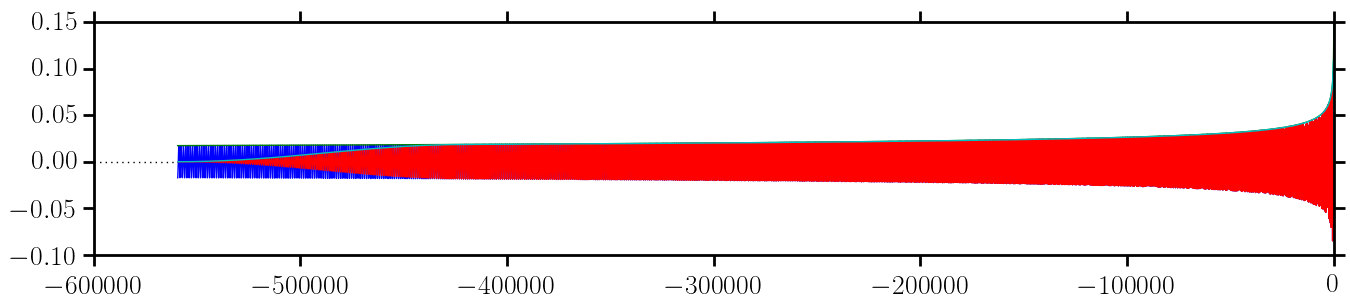

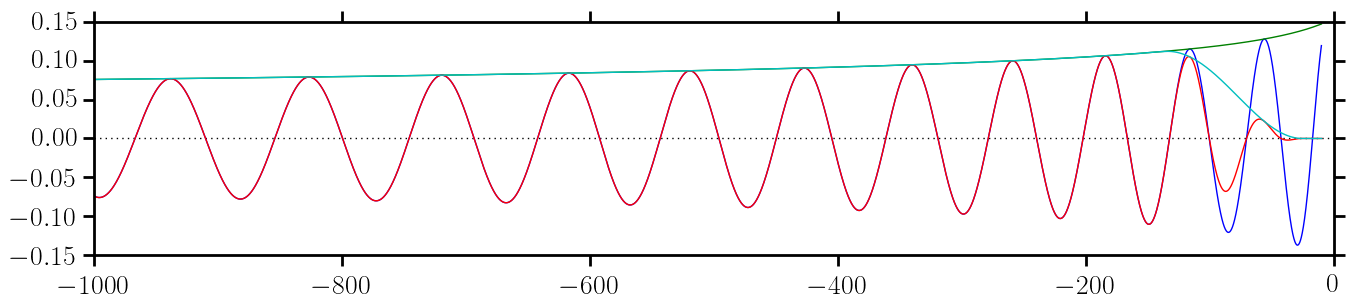

In [5]:
q, lambda1, lambda2 = 0.5, 0, 0
mf_lower, delta_tbym = 0.0009, 10.0
h = dimensionless_td_waveform(q, lambda1, lambda2, mf_lower, delta_tbym, approximant='TaylorT4')
hwin = window_waveform_in_frequency_interval(h, 0.001, 0.015, 0.020)

fig, axes = plt.subplots(1, figsize=(16, 3))
plot_waveforms(axes, [h, hwin], npoints=10000)

fig, axes = plt.subplots(1, figsize=(16, 3))
plot_waveforms(axes, [h, hwin], xi=-1000, npoints=10000)

In [6]:
q, lambda1, lambda2 = 1.0, 500, 500
mf_lower, delta_tbym = 0.0009, 10.0
length = 1.0e6
mfon_end, mfoff_start, mfoff_end = 0.001, 0.015, 0.020
mftrunc_start = mfon_end
f_fitend = 0.002

h = conditioned_waveform(q, lambda1, lambda2, mf_lower, delta_tbym, length, mfon_end, mfoff_start, mfoff_end, mftrunc_start)
h = match_taylorf2_at_beginning(h, q, lambda1, lambda2, f_fitend)

# TaylorF2 waveform starting at the dimensionless frequency corresponding to 10Hz (for 1.4-1.4M_sun system).
f2_lower = f_to_mf(10, 2.8)
f2_upper = MF_ISCO
hf2 = taylorf2(0, 0, q/(1+q)**2, lambda1, lambda2, f2_lower, f2_upper, 1.0e-5)

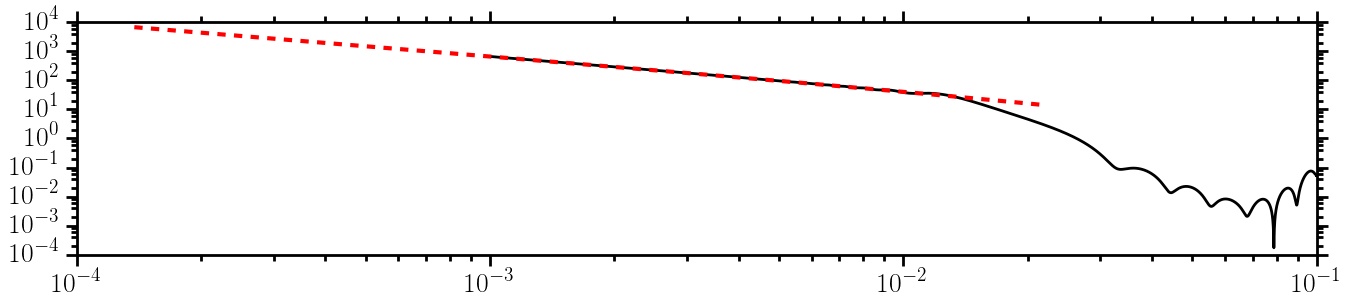

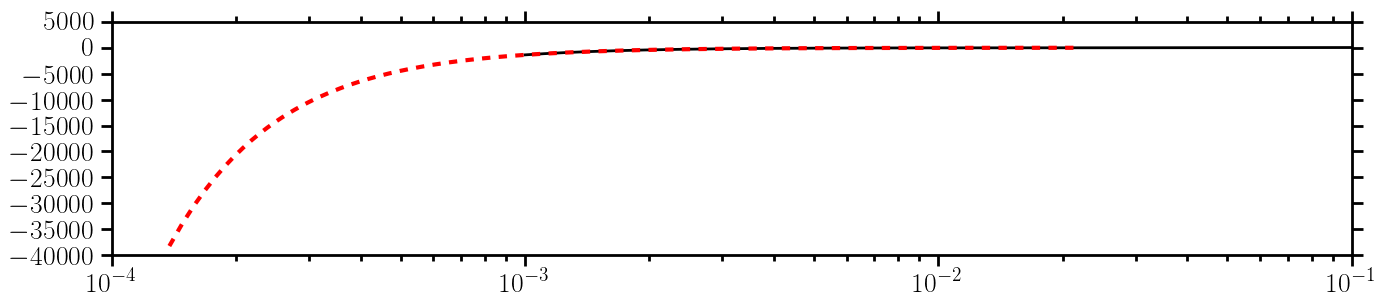

In [8]:
fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(h.x, h.amp, c='k', lw=2)
axes.plot(hf2.x, hf2.amp, c='r', lw=3, ls='--')
axes.set_xscale('log')
axes.set_yscale('log')

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(h.x, h.phase, c='k', lw=2)
axes.plot(hf2.x, hf2.phase, c='r', lw=3, ls='--')
axes.set_xscale('log')

In [10]:
q, lambda1, lambda2 = 1.0, 500, 500
mf_lower, delta_tbym = 0.0009, 10.0
length = 2.0e6
mfon_end, mfoff_start, mfoff_end = 0.001, 0.015, 0.020
mftrunc_start = mfon_end
f_fitend = 0.002

params = np.linspace(0.5, 1.0, 11)
#params = np.linspace(0, 5000, 51)
hlist = []
for p in params:
    print p, 
    h = conditioned_waveform(p, lambda1, lambda2, mf_lower, delta_tbym, 
                             length, mfon_end, mfoff_start, mfoff_end, mftrunc_start)
    h = match_taylorf2_at_beginning(h, p, lambda1, lambda2, f_fitend)
    hlist.append(h)

 0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0


0.021 1522.69082638


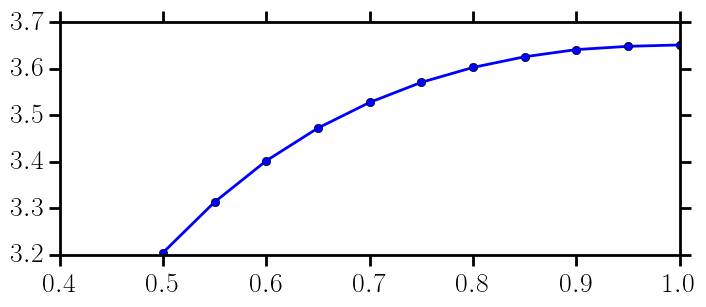

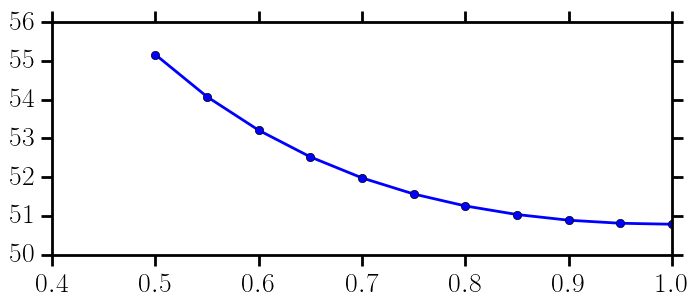

In [11]:
f = 0.021
print f, mf_to_f(f, 2.8)

amps = []
for h in hlist:
    amp = h.interpolate('amp')(f)
    amps.append(amp)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params, amps, 'o', ls='-', lw=2)


phis = []
for h in hlist:
    phi = h.interpolate('phase')(f)
    phis.append(phi)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params, phis, 'o', ls='-', lw=2)

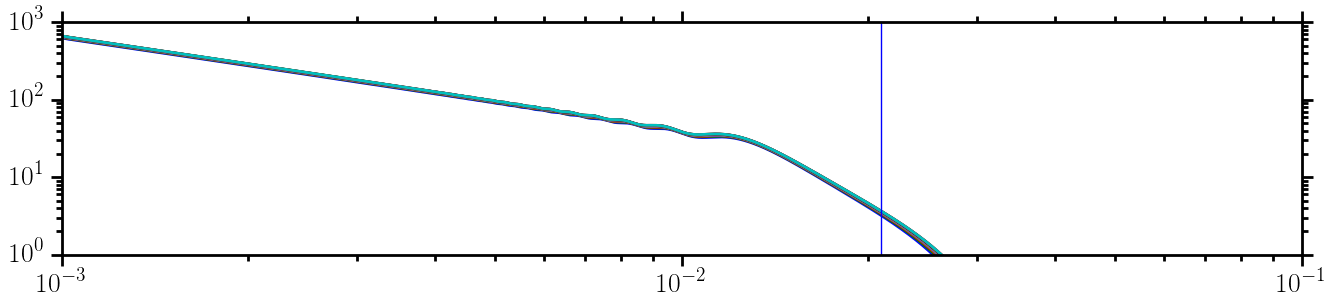

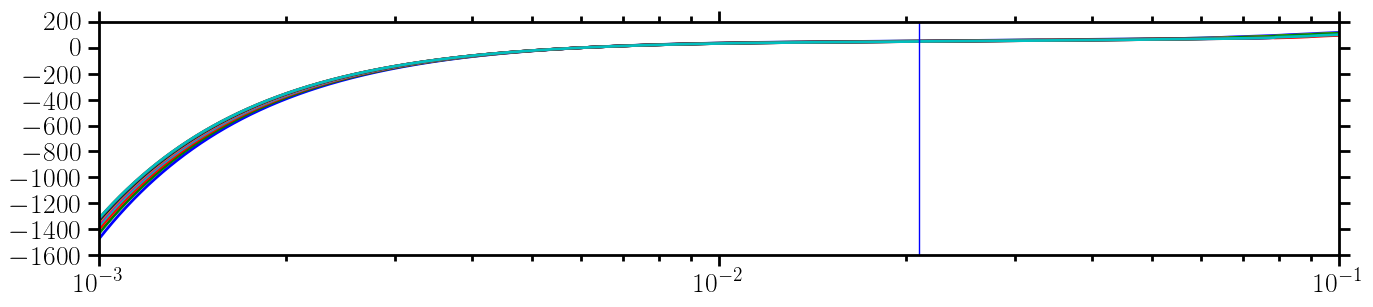

In [12]:
fig, axes = plt.subplots(1, figsize=(16, 3))
for h in hlist:
    axes.plot(h.x, h.amp, lw=2)
axes.axvline(f)
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_ylim(1.0e0, 1.0e3)


fig, axes = plt.subplots(1, figsize=(16, 3))
for h in hlist:
    axes.plot(h.x, h.phase, lw=2)
    #axes.plot(h.x, h.phase-hlist[0].phase, lw=2)
axes.axvline(f)
axes.set_xscale('log')

# Compare with TaylorF2 over parameter space

0.01 725.090869704













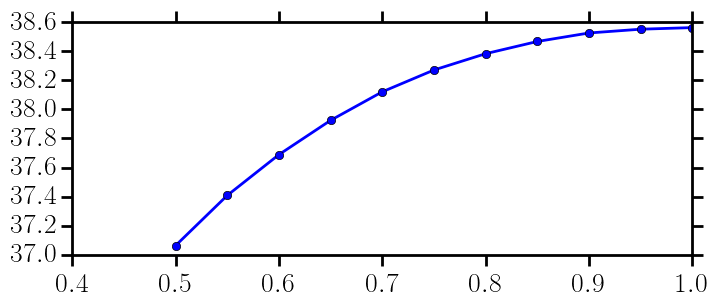

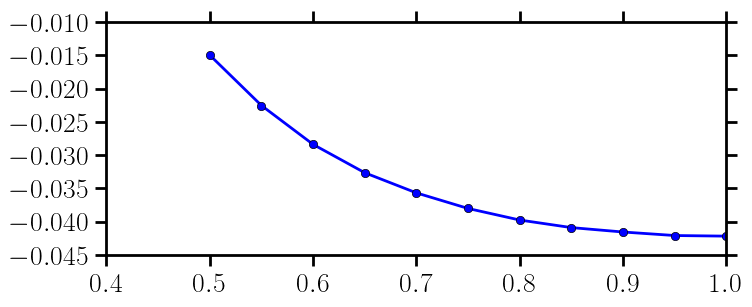

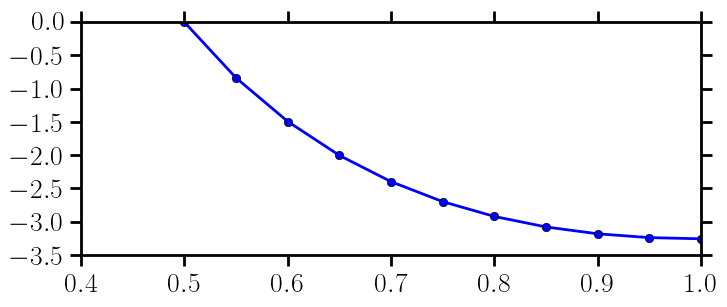

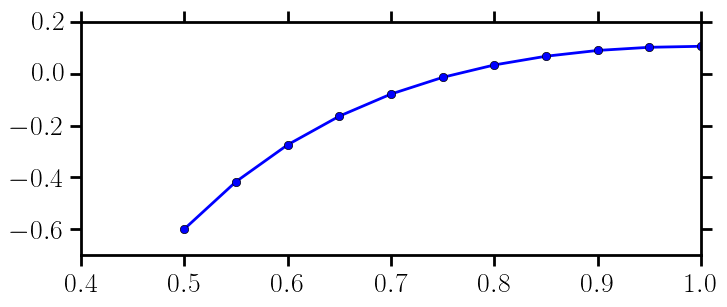

In [13]:
f = 0.01
print f, mf_to_f(f, 2.8)

amps = []
amp_err = []
for i in range(len(params)):
    h = hlist[i]
    q = params[i]
    amp = h.interpolate('amp')(f)
    ampf2 = taylorf2_amp(f, q/(1+q)**2)
    amps.append(amp)
    amp_err.append(amp/ampf2-1.0)
    

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params, amps, 'o', ls='-', lw=2)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params, amp_err, 'o', ls='-', lw=2)
#axes.set_ylim(-0.50, 0.50)


phi_err = []
phis = []
for i in range(len(params)):
    h = hlist[i]
    q = params[i]
    phi = h.interpolate('phase')(f)
    phif2 = taylorf2_phase(f, 0.0, 0.0, q/(1+q)**2, lambda1, lambda2)
    phis.append(phi)
    phi_err.append(phi-phif2)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params, phis-phis[0], 'o', ls='-', lw=2)
#axes.plot(params, phis, 'o', ls='-', lw=2)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params, phi_err, 'o', ls='-', lw=2)

# Compare with TaylorF2 for single waveform

In [14]:
q, lambda1, lambda2 = 0.5, 5000, 5000
mf_lower, delta_tbym = 0.0009, 10.0
length = 1.0e6
mfon_end, mfoff_start, mfoff_end = 0.001, 0.015, 0.020
mftrunc_start = mfon_end
f_fitend = 0.002

# Original waveform
h = conditioned_waveform(q, lambda1, lambda2, 
                         mf_lower, delta_tbym, length, mfon_end, mfoff_start, mfoff_end, mftrunc_start,
                        approximant='TaylorT4')
h = match_taylorf2_at_beginning(h, q, lambda1, lambda2, f_fitend)
f2_phase = taylorf2_phase(h.x, 0.0, 0.0, q/(1+q)**2, lambda1, lambda2)

(-100, 20)

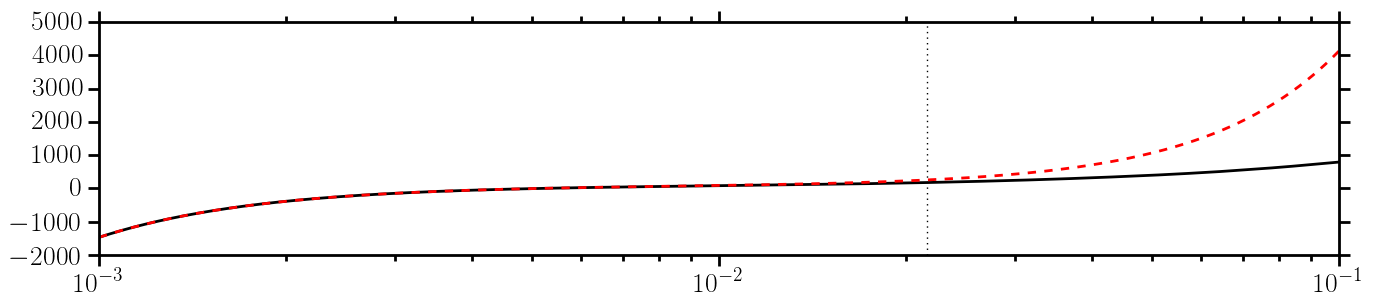

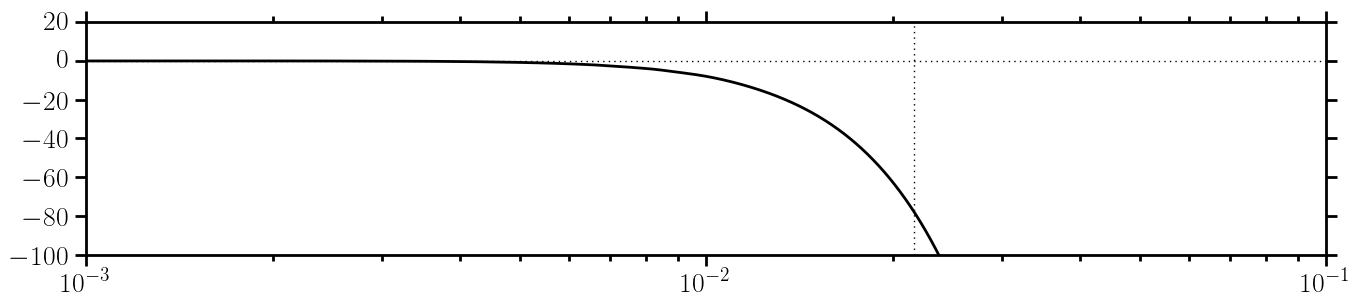

In [15]:
fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(h.x, h.phase, c='k', lw=2)
axes.plot(h.x, f2_phase, c='r', lw=2, ls='--')
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
#axes.set_yscale('symlog', linthreshy=1.0)


# Difference
diff = h.phase - f2_phase

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(h.x, diff, c='k', lw=2)
axes.axhline(0.0, c='k', ls=':', lw=1)
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
axes.set_ylim(-100, 20)
#axes.minorticks_on()
#axes.set_yscale('symlog', linthreshy=1.0)

In [16]:
f = 0.022
lambda1, lambda2 = 0, 1000

q=0.5
print taylorf2_phase(f, 0.0, 0.0, q/(1+q)**2, lambda1, lambda2)-taylorf2_phase(f, 0.0, 0.0, q/(1+q)**2, 0, 0)

q=1.0
print taylorf2_phase(f, 0.0, 0.0, q/(1+q)**2, lambda1, lambda2)-taylorf2_phase(f, 0.0, 0.0, q/(1+q)**2, 0, 0)



4.22927053332


15.1122698984


In [17]:
f_to_mf(400, 2.8), MF_ISCO

(0.005516549948608805, 0.021658244478713225)

# Compare to pycbc TaylorF2

In [7]:
q, lambda1, lambda2 = 0.5, 5000, 100
mf_lower, mf_upper, delta_mf = 0.001, 0.05, 5.0e-7

# My TaylorF2 waveform
hf2 = taylorf2(0.0, 0.0, q/(1+q)**2, lambda1, lambda2, mf_lower, mf_upper, delta_mf)

# PYCBC TaylorF2 waveform
hpycbcf2 = dimensionless_fd_waveform(q, lambda1, lambda2, mf_lower, delta_mf, approximant='TaylorF2')

# TaylorT4
mf_lower, delta_tbym = 0.0009, 10.0
length = 1.0e6
mfon_end, mfoff_start, mfoff_end = 0.001, 0.015, 0.020
mftrunc_start = mfon_end
f_fitend = 0.002
ht4 = conditioned_waveform(q, lambda1, lambda2, 
                         mf_lower, delta_tbym, length, mfon_end, mfoff_start, mfoff_end, mftrunc_start,
                        approximant='TaylorT4')
ht4 = match_taylorf2_at_beginning(h, q, lambda1, lambda2, f_fitend)

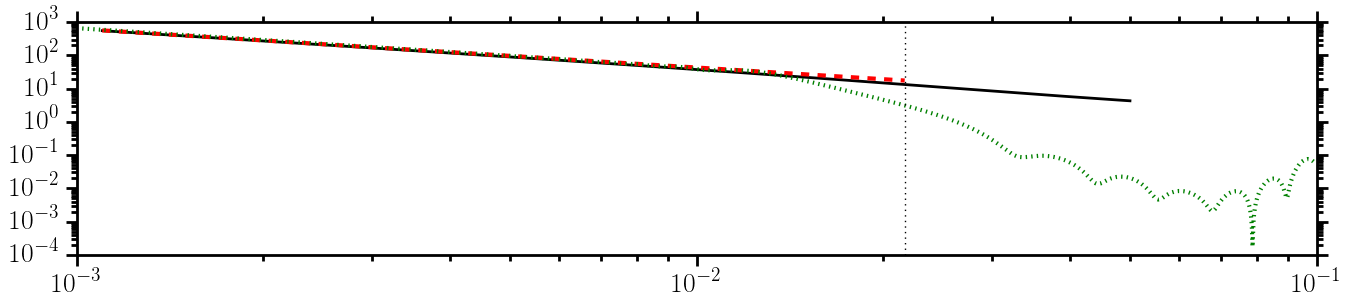

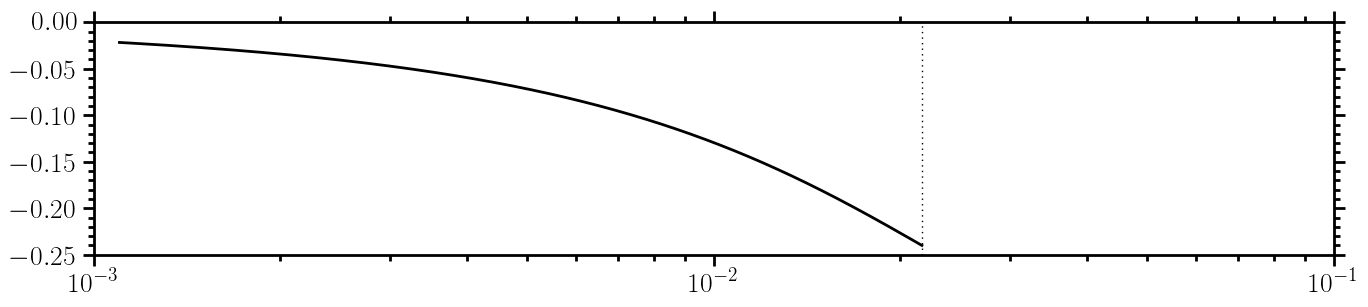

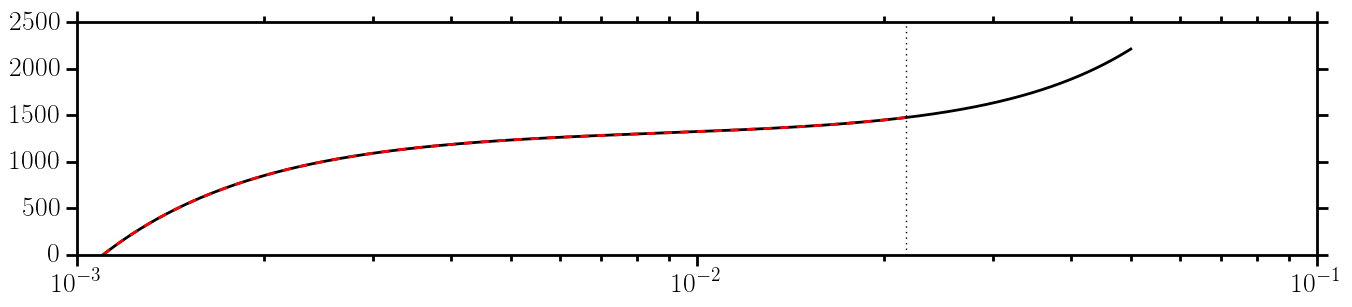

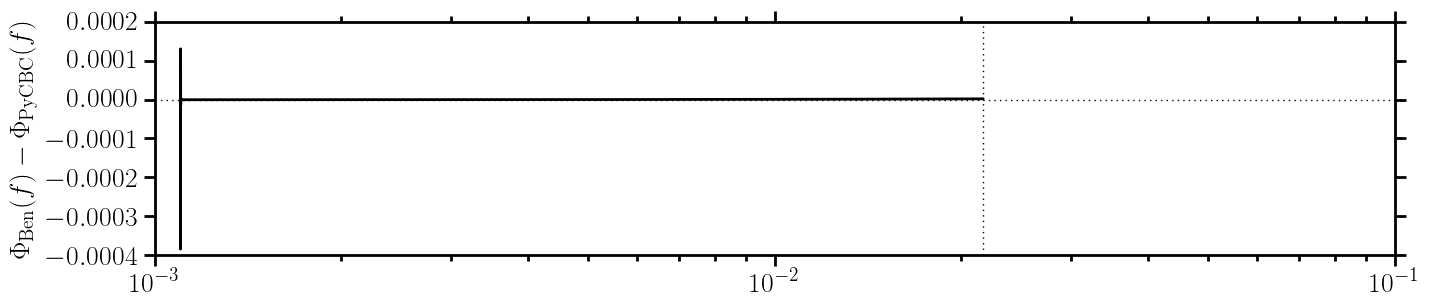

In [8]:
mf_start = 0.0011
hf2 = truncate_beginning(hf2, mf_start, remove_start_phase=True)
hpycbcf2 = truncate_beginning(hpycbcf2, mf_start, remove_start_phase=True)

# Phase difference
diff = subtract_waveform_phase(hf2, hpycbcf2, npoints=10000, spacing='log')

# Fractional amplitude difference
amp_ratio = waveform_amplitude_ratio(hf2, hpycbcf2, npoints=10000, spacing='log')


###### Amplitude ######
fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(hf2.x, hf2.amp, c='k', lw=2)
axes.plot(hpycbcf2.x, hpycbcf2.amp, c='r', lw=3, ls='--')
axes.plot(ht4.x, ht4.amp, c='g', lw=3, ls=':')
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
axes.set_yscale('log')

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(amp_ratio.x, amp_ratio.amp-1.0, c='k', lw=2)
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
#axes.set_yscale('log')
axes.minorticks_on()

####### Phase #######

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(hf2.x, hf2.phase, c='k', lw=2)
axes.plot(hpycbcf2.x, hpycbcf2.phase, c='r', lw=2, ls='--')
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(diff.x, diff.phase, c='k', lw=2)
axes.axhline(0.0, c='k', ls=':', lw=1)
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
axes.set_ylabel(r'$\Phi_{\rm Ben}(f)-\Phi_{\rm PyCBC}(f)$')
#axes.minorticks_on()
#axes.set_yscale('symlog', linthreshy=1.0)

# Resampling functions

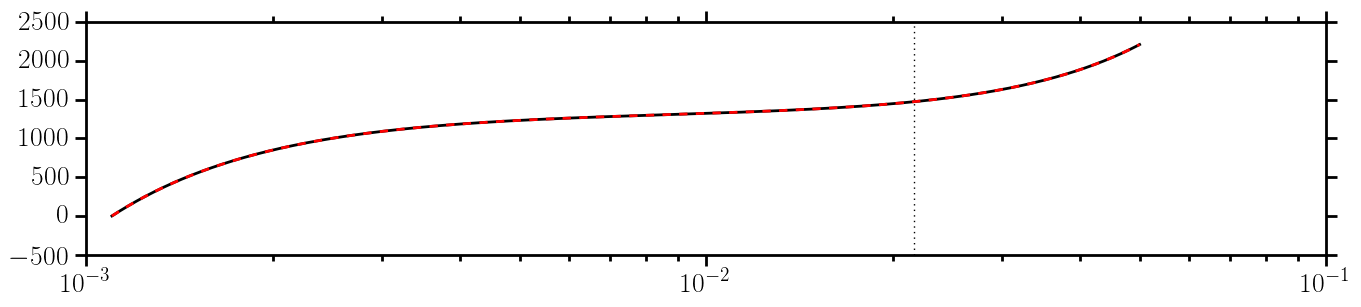

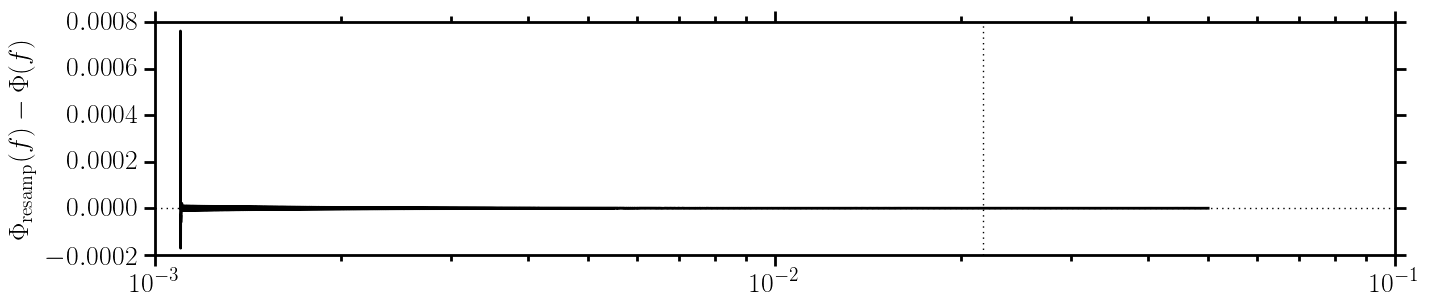

In [9]:
npoints = 1000
hf2resamp = hf2.copy()
resample_uniform(hf2resamp, npoints, spacing='log', order=3)


fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(hf2resamp.x, hf2resamp.phase, c='k', lw=2)
axes.plot(hf2.x, hf2.phase, c='r', lw=2, ls='--')
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')

# Difference
diff = subtract_waveform_phase(hf2resamp, hf2, npoints=100000, spacing='log')

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(diff.x, diff.phase, c='k', lw=2)
axes.axhline(0.0, c='k', ls=':', lw=1)
axes.axvline(MF_ISCO, c='k', ls=':', lw=1)
axes.set_xscale('log')
axes.set_ylabel(r'$\Phi_{\rm resamp}(f)-\Phi(f)$')
#axes.minorticks_on()
#axes.set_yscale('symlog', linthreshy=1.0)